In [2]:
import torch
import torch.utils.data as data
from pathlib import Path
from PIL import Image
import numpy as np
import json

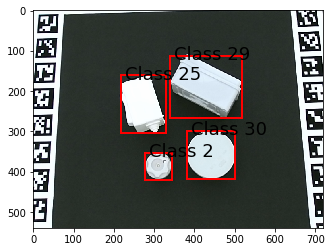

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms import ToTensor


class TLessRealDataset(data.Dataset):
    """Provides access to images, bboxes and classids for TLess real dataset.
    
    Download dataset
    https://bop.felk.cvut.cz/datasets/#T-LESS
    http://ptak.felk.cvut.cz/6DB/public/bop_datasets/tless_test_primesense_bop19.zip
    
    Format description 
    https://github.com/thodan/bop_toolkit/blob/master/docs/bop_datasets_format.md
    
    We also support the old yaml format
    https://github.com/thodan/t-less_toolkit/blob/master/doc/t-less_doc.md
    """
    def __init__(self, basepath, image_transform=None):
        self.basepath = Path(basepath)
        self.image_transform = image_transform
        assert self.basepath.exists()
        
        # 000001, 000002,...
        self.all_rgbpaths = []
        self.all_bboxes = []
        self.all_clsids = []
        
        scenes = [f for f in self.basepath.iterdir() if f.is_dir()]
        for scenepath in scenes:
            is_bop_format = (scenepath / 'scene_gt.json').exists()
            is_old_format = (scenepath / 'gt.yml').exists()
            assert is_bop_format or is_old_format, 'Cannot determine format.'
            
            if is_bop_format:
                rgbpaths, bboxes, clsids = self._parse_bop_scene(scenepath, 0.3)
            else:
                rgbpaths, bboxes, clsids = self._parse_old_format(scenepath, 0.3)
                
            self.all_rgbpaths.extend(rgbpaths)
            self.all_bboxes.extend(bboxes)
            self.all_clsids.extend(clsids)
                
    def __len__(self):
        return len(self.all_rgbpaths)
    
    def __getitem__(self, idx):
        img = Image.open(str(self.all_rgbpaths[idx])).convert('RGB')        
        if self.image_transform is not None:
            img = self.image_transform(img)
        return img, self.all_bboxes[idx], self.all_clsids[idx]
    
    def _parse_bop_scene(self, scenepath, vis_threshold):
        with open(scenepath / 'scene_gt.json', 'r') as fp:
            scene_gt = json.loads(fp.read())
        with open(scenepath / 'scene_gt_info.json', 'r') as fp:
            scene_gt_info = json.loads(fp.read())
            
        all_rgbpaths = []
        all_bboxes = []
        all_clsids = []
        
        for idx in scene_gt.keys():
            paths = [scenepath / 'rgb' / f'{int(idx):06d}.{ext}' for ext in ['png', 'jpg']]
            paths = [p for p in paths if p.exists()]
            assert len(paths)==1
            rgbpath = paths[0]

            clsids = [int(e['obj_id']) for e in scene_gt[idx]]
            bboxes = [e['bbox_obj'] for e in scene_gt_info[idx]]
            
            cids = [int(e['obj_id']) for e in scene_gt[idx]]
            bboxes = [e['bbox_visib'] for e in scene_gt_info[idx]]

            # visib_fract takes the inter-object coverage into account
            # thus we can avoid bboxes of covered objects
            # AND by taking the bbox_visib ones we have all bbox edges 
            # INSIDE of the image and hence no further preprocessing needed
            # before feeding into albumentation's transformations 
            visib_fracts = [e['visib_fract'] for e in scene_gt_info[idx]]

            filtered_bboxes, filtered_cids = [], []

            # filter bboxes by visibility:
            for bbox, cid, vis in zip(bboxes, cids, visib_fracts):
                if vis > vis_threshold:
                    filtered_bboxes.append(bbox)
                    filtered_cids.append(cid)

            if len(filtered_bboxes) > 0:  # only add non empty images                
                all_rgbpaths.append(rgbpath)
                # list of n_objs x 4
                all_bboxes.append(np.array(filtered_bboxes))
                # list of n_objs,
                all_clsids.append(np.array(filtered_cids))
            
        return all_rgbpaths, all_bboxes, all_clsids
    
    def _parse_old_format(self, scenepath, vis_threshold):
        del vis_threshold
        import yaml
        
        with open(scenepath / 'gt.yml', 'r') as fp:            
            scene_gt = yaml.load(fp.read(), Loader=yaml.Loader)
            
        all_rgbpaths = []
        all_bboxes = []
        all_clsids = []
        
        for idx in scene_gt.keys():
            rgbpath = scenepath / 'rgb' / f'{int(idx):04d}.png'
            #assert rgbpath.exists()
            
            clsids = [int(e['obj_id']) for e in scene_gt[idx]]
            bboxes = [e['obj_bb'] for e in scene_gt[idx]]
                       
            all_rgbpaths.append(rgbpath)
            all_bboxes.append(np.array(bboxes))
            all_clsids.append(np.array(clsids))
            
        return all_rgbpaths, all_bboxes, all_clsids            


        
ds = TLessRealDataset(r'C:\data\tless_test_kinect', image_transform=ToTensor())
dl = data.DataLoader(ds, batch_size=1) # batch_size=1 recommended, according to docs images are variably cropped.

img, bboxes, cids = next(iter(dl))

fig, axs = plt.subplots()
axs.imshow(img[0].permute(1,2,0), origin='upper')
for cid, bbox in zip(cids[0],bboxes[0]):
    rect = patches.Rectangle(bbox[:2],bbox[2],bbox[3],linewidth=2,edgecolor='r',facecolor='none')
    axs.add_patch(rect)
    axs.text(bbox[0]+10, bbox[1]+10, f'Class {cid.item()}', fontsize=18)
plt.show()



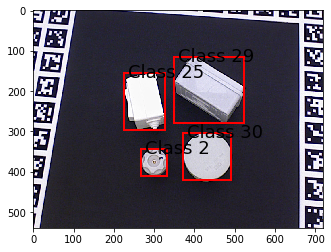

In [18]:
ds = TLessRealDataset(r'C:\data\tless_test_real\test_primesense', image_transform=ToTensor())
dl = data.DataLoader(ds, batch_size=1) # batch_size=1 recommended, according to docs images are variably cropped.

img, bboxes, cids = next(iter(dl))

fig, axs = plt.subplots()
axs.imshow(img[0].permute(1,2,0), origin='upper')
for cid, bbox in zip(cids[0],bboxes[0]):
    rect = patches.Rectangle(bbox[:2],bbox[2],bbox[3],linewidth=2,edgecolor='r',facecolor='none')
    axs.add_patch(rect)
    axs.text(bbox[0]+10, bbox[1]+10, f'Class {cid.item()}', fontsize=18)
plt.show()